In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import scipy.stats as st
from scipy.interpolate import make_interp_spline

# Да изпревариш вируса
## Представяне на модела, с който Юянг Ву прогнозира развитието на пандемията

## Резюме

В началото на ковид епидемията прогнозирането на нейното развитие се превърна в критично важна задача. В опитите си да изработят модел, който да осигури достатъчно добра симулация, се провалиха организации и научни звена с мултимилиарден бюджет. Същевременно моделът на Юянг Гу, изработен без никакви средства, без предварителни познания в областта на медицината и епидемиологията, се оказа изключително успешен.

Настоящата разработка е своеобразно допълнение към журналистическия материал по темата, който предстои да бъде публикуван на сайта [Дигитални истории](https://karamanev.me/digitalni/istorii/algoritamat-na-gu-v-presledvane-na-covid). В него се разказва подробно за общественото значение на проекта и е представена информационната страна на темата.

**[(Можете да намерите пълното му съдържание тук, смятам, че дава доста важни допълнения.)](https://karamanev.me/digitalni/istorii/algoritamat-na-gu-v-presledvane-na-covid)** 
  

### Моделът SEIR
Сайтът [covid19-projections.com](https://covid19-projections.com/) представя прогнозите за развитието на ситуацията с разпространението на коронавируса в 71 държави и всеки от американските щати. С успешните си прогнози той привлече сериозно внимание и позитивни оценки от водещи специалисти. 

След като проектът стана популярен, създателят му Юянг Гу [публикува в GitHub](https://github.com/youyanggu/yyg-seir-simulator) модела, който използва за своите прогнози.

В решението си той използва модела SEIR *(susceptible-exposed-infectious-recovered,  „податливи-изложени-инфектирани-възстановени)*, за да създаде симулация за броя на заразените, хоспитализираните и смъртните случаи за определена извадка на базата на избрани подадени параметри. 
![title](seir.png)



### Обработка от невронна мрежа

Важно е да се уточни, че според автора генерираната симулация не е прогноза. Тя става такава едва след като бъде обработена от следващото ниво - невронна мрежа (по-подробно по темата - **[тук.](https://docs.google.com/document/d/1UdYDbAIOs9lfjEwhPF5Sh0zrKDYacc1OVFlsf98-MA4/edit?usp=sharing)**). Освен това симулацията не представя пълния модел, използван от него, но е много близка по основните си показатели.

В реалния случай невронната мрежа съпоставя данните от многобройни (1000) итерации с различна тежест на показателите с реалните стойности за определена държава и на базата на това прави своята прогноза, която вече не е симулация, а се отличава със значително по-висока точност.

![title](model.png)


### Въвеждащи параметри

Моделът, избран от автора, цели да обработва минималния възможен брой параметри, разделени на две групи.


#### Константи
 
Фиксираните са тези, които е по-малко вероятно да варират, що се отнася до различните региони или държави. В случая те включват:
- Латентен период на вируса
- Период, в който носителят предава вируса
- Време между инфектирането и хоспитализацията
- Време между инфектирането и смъртта
- Период на възстановяване

Тези показатели многократно са актуализирани според данните на Световната здравна организация, като базовите са определени на базата на наблюденията от китайския град Ухан, където за първи път беше регистрирана инфекцията. 


#### Променливи

Променливите параметри са тези, които варират в зависимост от държавата или региона:
- R0 - основното репродуктивно число - средно колко души заразява един инфектиран. 
- Смъртност
- Брой на болните, влизащи от чужбина
- Влиянието на мерките като маски, локдаун и т.н.
- Население и гъстота на населението

Както отбелязва авторът на модела, с изключения на последния, всички останали показатели биха могли да варират драстично и именно това се получава в случая. Ето защо е избран моделът, при който невронна мрежа анализира данните за всяка страна или регион и „избира“ показалите се като най-точни показатели на променливите.

В SEIR модела, който използваме тук, авторът позволява да бъдат въвеждани всякакви променливи и със сравнително минимални намеси да се проверяват различни варианти - това, което в случая с прогнозирането изпълняват невронните мрежи. И все пак, той сам задава основни показатели, приети за най-добрите за съответния регион, които служат за базово изпробване на модела. Именно това предстои да направим.


### Приложение на модела

Симулаторът представлява Python проект, който е достатъчно „лек“, за да бъде стартиран от всеки, дори без базови познания. Единствените му изисквания са за Python и библиотеката Numpy.

Симулаторът позволява проследяването на различни сценарии. Например, какво би се случило, ако бъде въведена мярката социална дистанция седмица по-рано или ако 20% от заразените се карантинират доброволно, след като се появят първите симптоми на болестта.

Въведените обективни данни са за смъртните случаи в отделните региони от базата на научния център „Джонс Хопкинс“. Използвани са и официални данни за населението.

За да бъде елиминиран сериозният шум, е въведен изравняващ алгоритъм, благодарение на който при 0 смъртни случаи за дадена единица в определeн ден и 300 на следващия ден, данните се усредняват на 150.

Вземаме пример с данните за България с базовите параметри, без подаване на допълнителни променливи. Периодът на прогнозата е от началото на юни до края на октомври 2020 година, когато проектът вече не е поддържан по решение на неговия автор. Записваме данните в csv файл за по-лесна обработка.


In [6]:
# Генериране на симулация за България с базови параметри. 

# Тази стъпка е пропусната, тъй кат генерираният файл е включен в настоящото repository
# 
# %run  run_simulation.py -v --best_params_dir best_params/latest --country Bulgaria --save_csv_fname bg_simulation.csv


# Ограничаване на данните до начало 6 юни, период, за който има официални данни в използвания източник
simulator_data = pd.read_csv("bg_simulation.csv", skiprows = range(1,112))

# Изчистване на ненужните данни и форматиране
simulator_data["# dates"] = pd.to_datetime(simulator_data["# dates"], utc=True)
del simulator_data["mean_r_t"]
simulator_data.set_index("# dates")

simulator_data

,# dates,infections,hospitalizations,deaths
0,2020-06-06 00:00:00+00:00,1371.839937,151.0,2.508487
1,2020-06-07 00:00:00+00:00,1442.579035,154.0,2.515430
2,2020-06-08 00:00:00+00:00,1517.051210,157.0,2.517545
3,2020-06-09 00:00:00+00:00,1595.414187,160.0,2.516775
4,2020-06-10 00:00:00+00:00,1677.839328,165.0,2.514805
...,...,...,...,...
144,2020-10-28 00:00:00+00:00,3263.791068,682.0,6.287812
145,2020-10-29 00:00:00+00:00,3278.782418,682.0,6.296220
146,2020-10-30 00:00:00+00:00,3294.417987,684.0,6.305782
147,2020-10-31 00:00:00+00:00,3310.705306,685.0,6.316504


### Разпределение на основните показатели според симулацията

In [12]:
# Извеждане на основните показатели за симулатора в променливи
simulator_dates = simulator_data["# dates"]
simulator_hospitalisations = simulator_data["hospitalizations"] 
simulator_deaths = simulator_data["deaths"] 
simulator_cases = simulator_data["hospitalizations"]

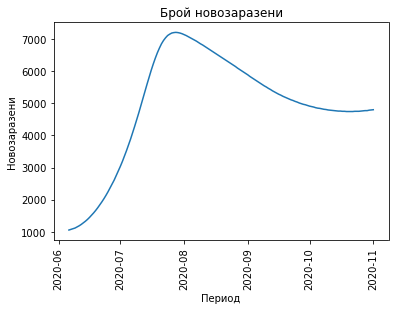

In [8]:
plt.title("Брой новозаразени")
plt.xlabel("Период")
plt.ylabel("Новозаразени")
plt.xticks(rotation=90)
plt.plot(simulator_dates, simulator_cases)

plt.show()

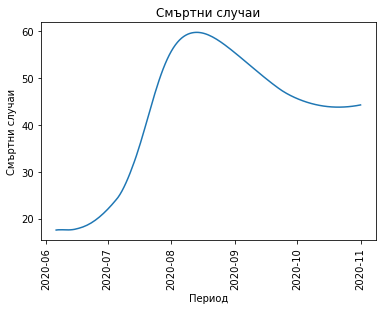

In [9]:
plt.title("Смъртни случаи")
plt.xlabel("Период")
plt.ylabel("Смъртни случаи")
plt.xticks(rotation=90)
plt.plot(simulator_dates, simulator_deaths)

plt.show()

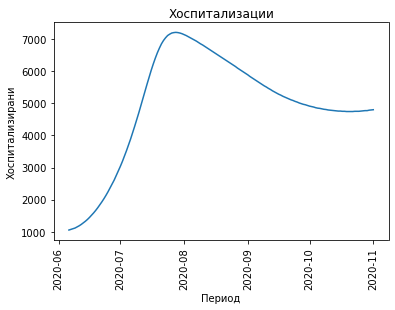

In [10]:
plt.title("Хоспитализации")
plt.xlabel("Период")
plt.ylabel("Хоспитализирани")
plt.xticks(rotation=90)
plt.plot(simulator_dates, simulator_hospitalisations)

plt.show()

### Разпределение на основните показатели според реалните данни

Източник: Официалният държавен сайт с информация за пандемията https://coronavirus.bg/

In [11]:
# Четене и ограничаване на крайната дата, за да съвпадне с прогнозираното
real_data = pd.read_csv("covid_bg_real_data.csv", skiprows = range(150,354))

# Изчистване на ненужните данни и форматиране
real_data["Дата"] = pd.to_datetime(real_data["Дата"], utc=True)
del real_data["Направени тестове"]
del real_data["Тестове за денонощие"]
del real_data["Потвърдени случаи"]
del real_data["Активни случаи"]
del real_data["В интензивно отделение"]
del real_data["Излекувани"]
del real_data["Излекувани за денонощие"]
del real_data["Починали"]
real_data.set_index("Дата")

real_data

,Дата,Нови случаи за денонощие,Хоспитализирани,Починали за денонощие
0,2020-06-06 00:00:00+00:00,41,147,1
1,2020-06-07 00:00:00+00:00,43,155,0
2,2020-06-08 00:00:00+00:00,16,158,0
3,2020-06-09 00:00:00+00:00,83,152,4
4,2020-06-10 00:00:00+00:00,79,161,3
...,...,...,...,...
144,2020-10-28 00:00:00+00:00,2569,2217,25
145,2020-10-29 00:00:00+00:00,2760,2316,36
146,2020-10-30 00:00:00+00:00,2689,2376,28
147,2020-10-31 00:00:00+00:00,2891,2447,29


In [14]:
# Извеждане на основните реални показатели в променливи

real_dates = real_data["Дата"]
real_hospitalisations = real_data["Хоспитализирани"]
real_deaths = real_data["Починали за денонощие"]
real_cases = real_data["Нови случаи за денонощие"]

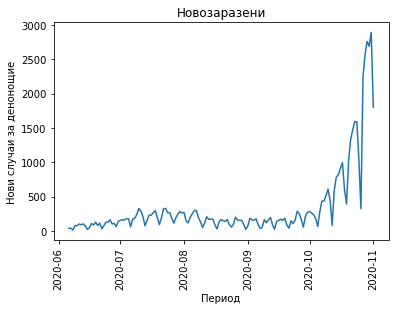

In [10]:
real_data.set_index("Дата")
plt.title("Новозаразени")
plt.xlabel("Период")
plt.ylabel("Нови случаи за денонощие")
plt.xticks(rotation=90)
plt.plot(real_dates, real_cases)

# TODO: Заглаждане на показателите за по-добро усредняване на дневна база

plt.show()

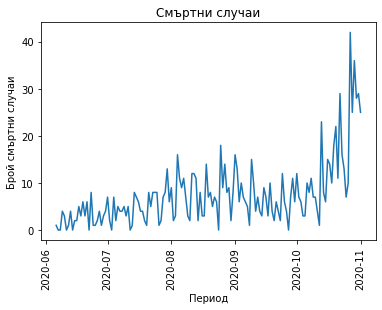

In [11]:
real_data.set_index("Дата")
plt.title("Смъртни случаи")
plt.xlabel("Период")
plt.ylabel("Брой смъртни случаи")
plt.xticks(rotation=90)
plt.plot(real_dates, real_deaths)

# TODO: Заглаждане на показателите за по-добро усредняване на дневна база

plt.show()

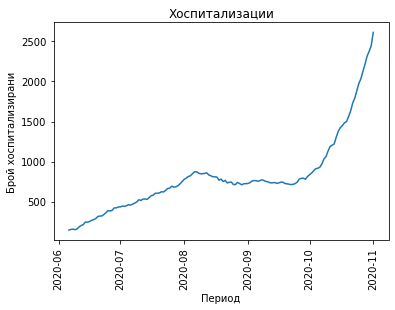

In [12]:
plt.title("Хоспитализации")
plt.xlabel("Период")
plt.ylabel("Брой хоспитализирани")
plt.xticks(rotation=90)
plt.plot(real_dates, real_hospitalisations)

plt.show()

### Съпоставка на данните от симулацията и реалните показатели

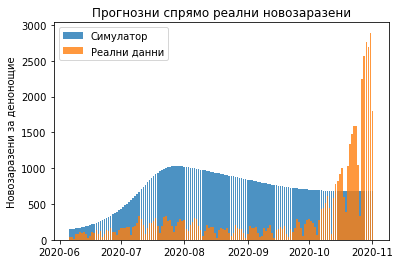

In [15]:
plt.bar(simulator_dates, simulator_cases, alpha = 0.8, label ="Симулатор" )
plt.bar(real_dates, real_cases, alpha = 0.8, label ="Реални данни")

plt.title("Прогнозни спрямо реални новозаразени")
plt.ylabel("Новозаразени за денонощие")
plt.legend()
plt.show()

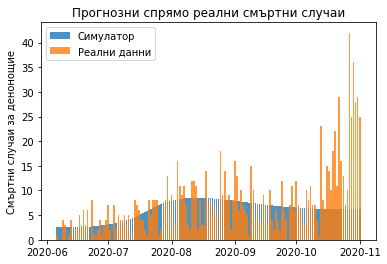

In [16]:
plt.bar(simulator_dates, simulator_deaths, alpha = 0.8, label ="Симулатор" )
plt.bar(real_dates, real_deaths, alpha = 0.8, label ="Реални данни")

plt.title("Прогнозни спрямо реални смъртни случаи")
plt.ylabel("Смъртни случаи за денонощие")
plt.legend()
plt.show()

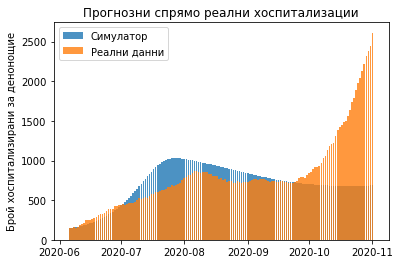

In [17]:
plt.bar(simulator_dates, simulator_hospitalisations, alpha = 0.8, label ="Симулатор" )
plt.bar(real_dates, real_hospitalisations, alpha = 0.8, label ="Реални данни")

plt.title("Прогнозни спрямо реални хоспитализации")
plt.ylabel("Брой хоспитализирани за денонощие")
plt.legend()
plt.show()

### Тестове


In [22]:
st.ttest_rel(simulator_cases, real_cases)

Ttest_relResult(statistic=7.786972111148174, pvalue=1.1015837746220514e-12)

In [23]:
st.ttest_rel(simulator_deaths, real_deaths)

Ttest_relResult(statistic=-2.6465407654772584, pvalue=0.009011741308633806)

In [24]:
st.ttest_rel(simulator_hospitalisations, real_hospitalisations)

Ttest_relResult(statistic=-2.6633647210081075, pvalue=0.008593169331583555)

In [27]:
st.ttest_ind(simulator_cases, real_cases)

Ttest_indResult(statistic=7.705733285810797, pvalue=5.150496568882534e-13)

In [28]:
st.ttest_ind(simulator_deaths, real_deaths)

Ttest_indResult(statistic=-2.3085622773457914, pvalue=0.02189162141868856)

In [29]:
st.ttest_ind(simulator_hospitalisations, real_hospitalisations)

Ttest_indResult(statistic=-2.3085622773457914, pvalue=0.02165681221216765)

### Изводи
- Недвусмислена е разликата между симулацията с уж идеалните параметри на модела и реалните показатели. На базата на всичко, което вече сме прочели за коронавируса, очевидно е, че има много сериозни специфики на статистиката, що се отнася до България. Затова би било изключително интересно да опитаме да променим параметрите, което ни позволява и авторът на модела.

- Броят на хоспитализациите и този на смъртните случаи показват доста по-висока корелация между прогнозираните и реалните стойности.

- Слоят на машинното самообучение очевидно изпълнява по впечатляващо добър начин анализа на данните, след като в публикуваните прогнози и официалното проследяване на статистиката за България се открива значително по-отчетлива закономерност **[(тук)](https://covid19-projections.com/bulgaria)**. Този тип анализиране на данните би могъл да даде интересни резултати и изводи.

- Без слоя на машинно самообучение моделът дава определена информация за тенденциите, но те са далеч отвъд математическите стандарти и е лесно да предположим, че не биха покрили базовите тестове за корелация.

- Фиксираният коефициент на смъртност на 1%, както отбелязва и самият автор на модела, изкривява до голяма степен данните по този показател. Това е допълнителен фактор, що се отнася до България, която според официалните статистики на СЗО е в челните позиции що се отнася именно до показателя смъртност.

### Използвани източници

https://covid19-projections.com/ 

https://covid19-projections.com/model-details/ 

https://www.technologyreview.com/2021/04/27/1023657/lessons-from-the-pandemics-superstar-data-scientist-youyang-gu/ 

https://www.bloomberg.com/news/articles/2021-02-19/covid-pandemic-how-youyang-gu-used-ai-and-data-to-make-most-accurate-prediction 

https://www.magzter.com/stories/Business/Bloomberg-Businessweek/Youyang-Gu-Covids-Data-Superstar 

https://ourworldindata.org/covid-models

https://cdc.gov/coronavirus/2019-ncov/covid-data/forecasting-us.html 

https://github.com/youyanggu/yyg-seir-simulator

https://coronavirus.bg/ 

https://youyanggu.com/blog/
